<a href="https://colab.research.google.com/github/Jansen-Pereira/CNN_handwriting_recognition/blob/main/CNN_handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import all required libraries**

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
import pandas as pd
import seaborn as sns
import cv2
import os

from keras import backend as K



K.set_image_data_format('channels_last')

%matplotlib inline

seed = 7
np.random.seed(seed)

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


# **Importing train and test data**

In [ ]:
def load_data():
    
    #Load data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
    # canal = 1 => For gray scale
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

    # Normalize data to make CNN faster
    x_train = x_train / 255
    x_test = x_test / 255

    # Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
    y_train1 = np_utils.to_categorical(y_train)
    y_test1 = np_utils.to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = load_data()
#num_classes = y_test.shape[1]

In [ ]:
print(f"Training data size is {x_train.shape}\nTesting data size is {y_test.shape}")

Training data size is (60000, 28, 28, 1)
Testing data size is (10000,)


# **Is The Target Label Balanced ?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


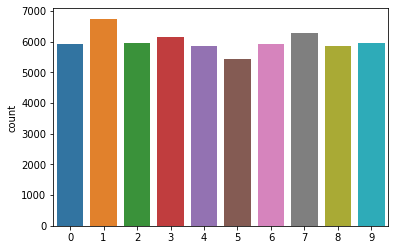

In [ ]:
# Print data histogram
sns.countplot(y_train)
#sns.histplot(data=y_train)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


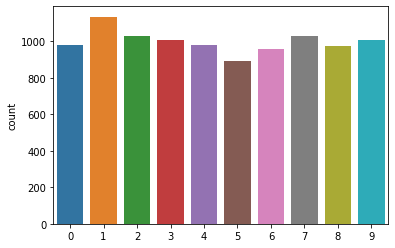

In [ ]:
# Print data histogram
sns.countplot(y_test)


# **Data Visualization**

In [ ]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

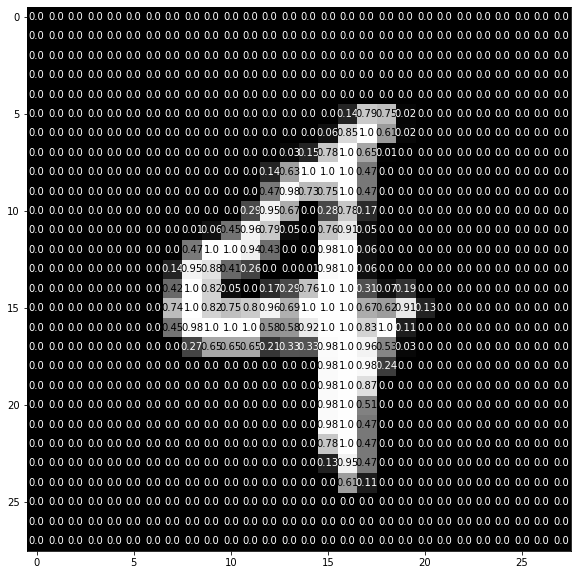

In [ ]:
import random
n = random.randrange(0,60000)

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[n].reshape(28,28), ax)

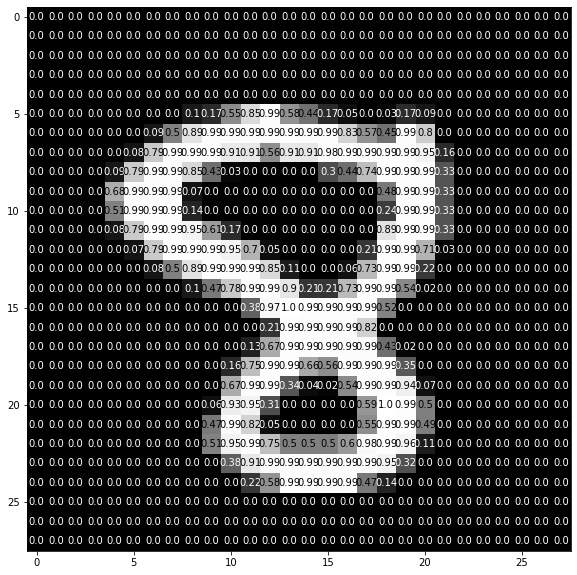

In [ ]:
import random
n = random.randrange(0,10000)

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_test[n].reshape(28,28), ax)

# **Model Definition**

In [ ]:
def model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation= 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Dropout(0.35))

    model.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), activation= 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Dropout(0.35))
    
    model.add(Conv2D(128, (5, 5), input_shape=(28, 28, 1), activation= 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Dropout(0.35))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='predict'))

    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
model = model()

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

# **Plot CNN model**

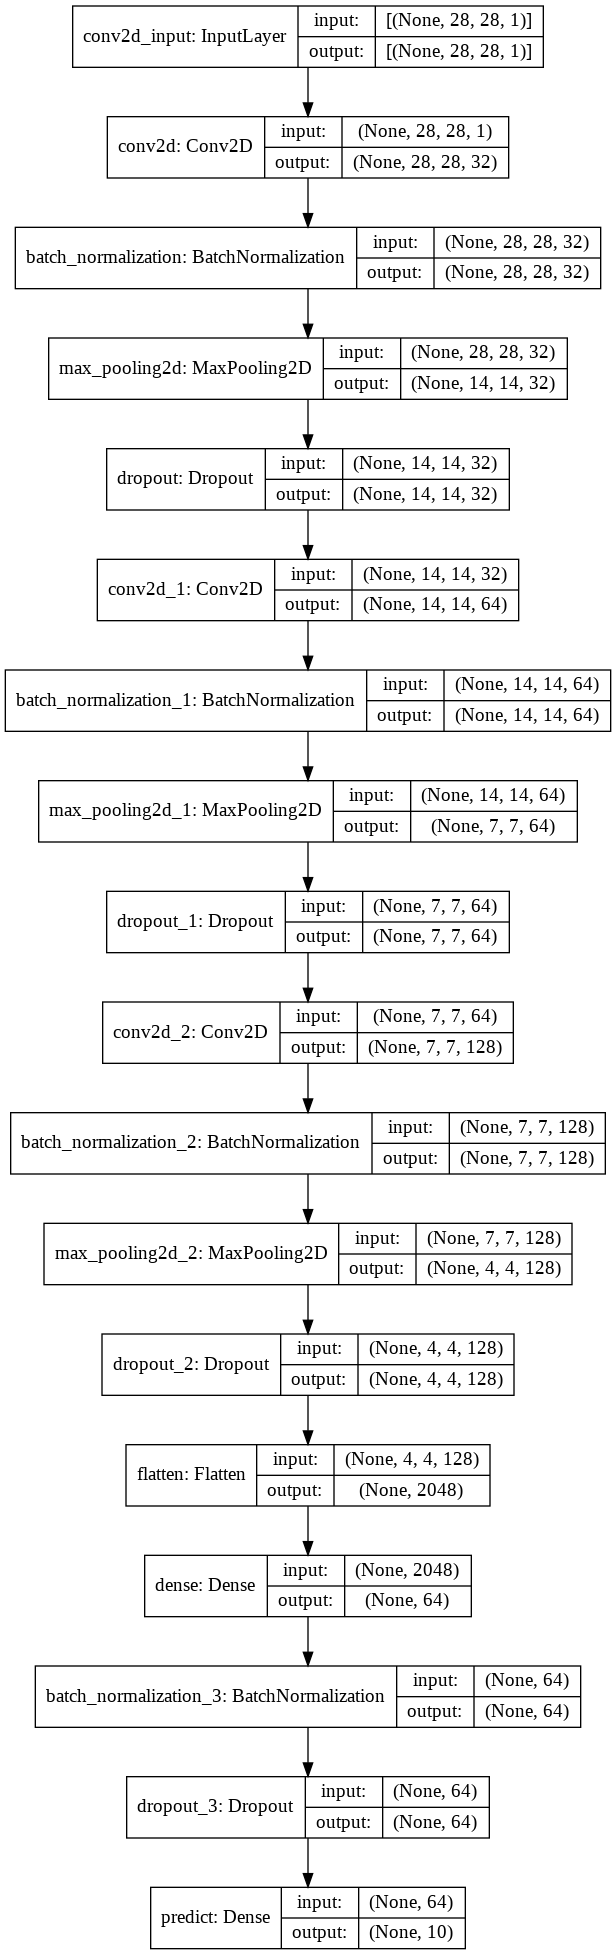

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [ ]:
from keras.callbacks import ModelCheckpoint   
from keras.callbacks import ReduceLROnPlateau


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

# **Model training**

In [ ]:
 history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=200, callbacks=[reduce_lr], shuffle=True, verbose=2)

Epoch 1/15
300/300 - 272s - loss: 0.3661 - accuracy: 0.8907 - val_loss: 2.5815 - val_accuracy: 0.2775
Epoch 2/15
300/300 - 267s - loss: 0.1023 - accuracy: 0.9709 - val_loss: 0.0854 - val_accuracy: 0.9742
Epoch 3/15
300/300 - 266s - loss: 0.0721 - accuracy: 0.9798 - val_loss: 0.0291 - val_accuracy: 0.9899
Epoch 4/15
300/300 - 266s - loss: 0.0608 - accuracy: 0.9831 - val_loss: 0.0229 - val_accuracy: 0.9920
Epoch 5/15
300/300 - 265s - loss: 0.0517 - accuracy: 0.9852 - val_loss: 0.0266 - val_accuracy: 0.9906
Epoch 6/15
300/300 - 265s - loss: 0.0466 - accuracy: 0.9860 - val_loss: 0.0310 - val_accuracy: 0.9908
Epoch 7/15
300/300 - 265s - loss: 0.0417 - accuracy: 0.9876 - val_loss: 0.0211 - val_accuracy: 0.9931
Epoch 8/15
300/300 - 265s - loss: 0.0388 - accuracy: 0.9888 - val_loss: 0.0206 - val_accuracy: 0.9932
Epoch 9/15
300/300 - 265s - loss: 0.0349 - accuracy: 0.9895 - val_loss: 0.0192 - val_accuracy: 0.9943
Epoch 10/15
300/300 - 265s - loss: 0.0339 - accuracy: 0.9901 - val_loss: 0.0244 - 

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("\n Test accuracy : %.2f%%" % (scores[1]*100))


 Test accuracy : 99.57%


# **Evaluate the model**

# **Create accuracy plot**

In [ ]:
def plot_accuracy(history):

  ax = plt.axes()
  
  ax.plot(history.history["accuracy"], label="train accuracy")
  ax.plot(history.history["val_accuracy"], label="test accuracy")
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Epoch")
  ax.legend(loc="lower right")
  ax.set_title("Accuracy eval")

  plt.show()



# **Create error plot**

In [ ]:
 def plot_error(history):

  fig = plt.figure()
  ax = plt.axes()

  ax.plot(history.history["loss"], label="train error")
  ax.plot(history.history["val_loss"], label="test error")
  ax.set_ylabel("Error")
  ax.set_xlabel("Epoch")
  ax.legend(loc="upper right")
  ax.set_title("Error eval")

  plt.show()

# **Plot accuracy and error over the epochs**


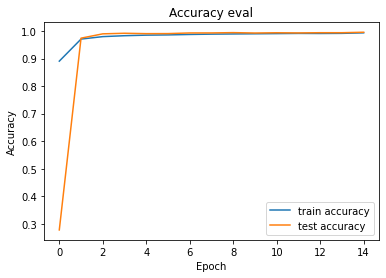

In [ ]:
plot_accuracy(history)

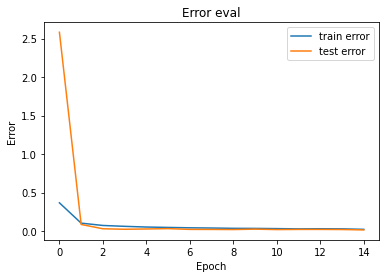

In [ ]:
plot_error(history)

# **Predict**




In [ ]:
predictions = model.predict(x_test, batch_size= 200, verbose=0)
rounded_predictions = np.argmax(predictions, axis=-1)


In [ ]:
rounded_labels = np.argmax(y_test, axis=1)


# **Confusion Matrix**


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:

cm = confusion_matrix(rounded_labels, rounded_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matriz, without normalization")

  print(cm)

  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion matriz, without normalization
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1    1 1027    0    0    0    0    3    0    0]
 [   0    0    0 1009    0    1    0    0    0    0]
 [   0    0    0    0  979    0    0    0    0    3]
 [   1    0    0    2    0  888    1    0    0    0]
 [   2    2    0    0    1    1  952    0    0    0]
 [   0    3    1    0    0    0    0 1023    0    1]
 [   0    1    1    1    0    1    0    1  967    2]
 [   0    0    0    0    3    2    0    2    2 1000]]


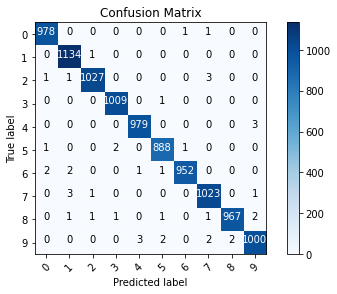

In [ ]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes= cm_plot_labels, title= 'Confusion Matrix')

In [ ]:
(a_train, b_train), (a_test, b_test) = mnist.load_data()



In [ ]:
import random
n = random.randrange(0,10000)
img_pred = a_test[n]
plt.imshow(img_pred)

if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)


img_pred = img_pred.reshape(1, 28, 28, 1).astype('float32')

img_pred = img_pred/255.0


predict_x=model.predict(img_pred) 
classes_x=np.argmax(predict_x,axis=1)


print("\n Classe: ", classes_x)
print("\n Probability: ", predict_x [0][classes_x[0]]*100, "%")
print("\n", predict_x)

NameError: ignored


 Classe:  [5]

 Probability:  99.98773336410522 %

 [[7.43886872e-08 3.88741654e-07 1.53487101e-09 1.11646645e-04
  1.61302971e-08 9.99877334e-01 1.87158534e-07 3.04907068e-08
  9.71762438e-06 6.33130469e-07]]


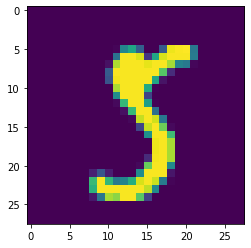

In [ ]:
import random
n = random.randrange(0,60000)
img_pred = a_train[n]
plt.imshow(img_pred)


if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)


img_pred = img_pred.reshape(1, 28, 28, 1).astype('float32')

img_pred = img_pred/255.0


predict_x=model.predict(img_pred) 
classes_x=np.argmax(predict_x,axis=1)


print("\n Classe: ", classes_x)
print("\n Probability: ", predict_x [0][classes_x[0]]*100, "%")
print("\n", predict_x)


 Classe:  [8]

 Probability:  71.14207148551941 %

 [[0.01300266 0.00435792 0.0205708  0.02379621 0.01143018 0.00109701
  0.00154082 0.00944436 0.7114207  0.20333934]]


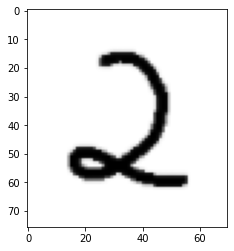

In [ ]:
img_pred = cv2.imread("/content/drive/MyDrive/CNN - image/number-two.png", 0)
plt.imshow(img_pred, cmap='gray')

if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)


img_pred = img_pred.reshape(1, 28, 28, 1).astype('float32')

img_pred = img_pred/255.0


predict_x=model.predict(img_pred) 
classes_x=np.argmax(predict_x,axis=1)


print("\n Classe: ", classes_x)
print("\n Probability: ", predict_x [0][classes_x[0]]*100, "%")
print("\n", predict_x)



 Classe:  [8]

 Probability:  63.28392028808594 %

 [[0.00925243 0.00463779 0.00136688 0.01758497 0.11678538 0.00279864
  0.00676283 0.02262304 0.6328392  0.18534878]]


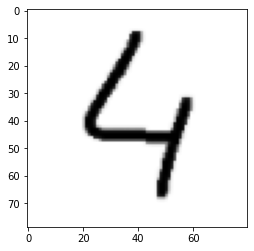

In [ ]:
img_pred = cv2.imread("/content/drive/MyDrive/CNN - image/number-four.png", 0)
plt.imshow(img_pred, cmap='gray')

if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)


img_pred = img_pred.reshape(1, 28, 28, 1).astype('float32')

img_pred = img_pred/255.0


predict_x=model.predict(img_pred) 
classes_x=np.argmax(predict_x,axis=1)


print("\n Classe: ", classes_x)
print("\n Probability: ", predict_x [0][classes_x[0]]*100, "%")
print("\n", predict_x)


 Classe:  [8]

 Probability:  75.09137392044067 %

 [[0.00243749 0.00111369 0.00102089 0.0293244  0.00340306 0.00577805
  0.00176344 0.0066966  0.75091374 0.19754873]]


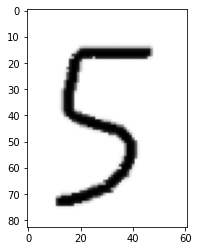

In [ ]:
img_pred = cv2.imread("/content/drive/MyDrive/CNN - image/number-five.png", 0)
plt.imshow(img_pred, cmap='gray')

if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)


img_pred = img_pred.reshape(1, 28, 28, 1).astype('float32')

img_pred = img_pred/255.0


predict_x=model.predict(img_pred) 
classes_x=np.argmax(predict_x,axis=1)


print("\n Classe: ", classes_x)
print("\n Probability: ", predict_x [0][classes_x[0]]*100, "%")
print("\n", predict_x)